# Segmentation of Air and Traffic


## Traffic segmentation with ClaSP

In [2]:
%load_ext autoreload
%autoreload 2

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sktime.annotation.clasp import ClaSPSegmentation, find_dominant_window_sizes
# from sktime.annotation.plotting.utils import (
#     plot_time_series_with_change_points,
#     plot_time_series_with_profiles,
# )

traffic_df = pd.read_feather("../01-data/processed/traffic_data.feather")
# Most frequent traffic station codes
traffic_df.cod_cent.value_counts().head(20)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


PM41852    35217
PM20777    35114
PM43223    35094
PM41302    35082
PM10948    35057
PM20776    34892
PM41802    34873
PM30462    34762
PM33152    34728
PM32352    34711
PM30902    34704
PM30472    34659
PM10765    34554
PM13014    34460
PM10768    34347
PM41882    34305
PM43012    34179
PM10486    34157
PM13221    34065
PM10446    34020
Name: cod_cent, dtype: int64

In [3]:
# Make time series dataframe for ClaSPSegmentation
start = "2015-12-01"
end = "2019-12-30"
station_cod = "PM10446" #unique_codes.s 
# Serie de tiempo de la intensidad de trafico
df =  traffic_df
ts_df = df[(df.cod_cent==station_cod)&(df.fecha>start)&(df.fecha<end)]\
            .astype({"fecha":"datetime64"})\
                .set_index("fecha")\
                    .resample("12H").mean()\
                        .loc[:,"intensidad"]\
                                .dropna()\
                                    .sort_index().reset_index()
# A la estacion 05FT10PM01 le faltan los meses de septiembre hasta noviembre de 2018
ts_df

fecha   intensidad
0    2016-04-15 00:00:00     0.000000
1    2016-04-15 12:00:00     0.000000
2    2016-04-16 00:00:00     0.000000
3    2016-04-22 12:00:00     0.000000
4    2016-04-23 00:00:00     0.000000
...                  ...          ...
1566 2019-12-27 12:00:00  1334.833333
1567 2019-12-28 00:00:00   440.020833
1568 2019-12-28 12:00:00  1234.062500
1569 2019-12-29 00:00:00   387.062500
1570 2019-12-29 12:00:00  1163.291667

[1571 rows x 2 columns]

In [4]:
# Run ClaSP
ts = ts_df.intensidad.copy() #.set_index("fecha")
dominant_period_size = find_dominant_window_sizes(ts)
clasp = ClaSPSegmentation(period_length=dominant_period_size, n_cps=1, fmt="dense")
found_segmentation = clasp.fit_predict(ts)
profiles = clasp.profiles
scores = clasp.scores

In [5]:
# Get change points
ts_df["segment"] = 0
for i,interval in enumerate(found_segmentation.to_list()):
    ts_df.iloc[interval.left:interval.right,-1] = i
cps = pd.Series([interval.left for interval in found_segmentation if interval.left!=0 and interval.right!=(len(ts_df)-1)]).unique()
change_points_df = ts_df.iloc[cps].copy()
change_points_df["scores"] = scores
change_points_df

fecha  intensidad  segment    scores
1117 2019-05-17  704.208333        1  0.533658

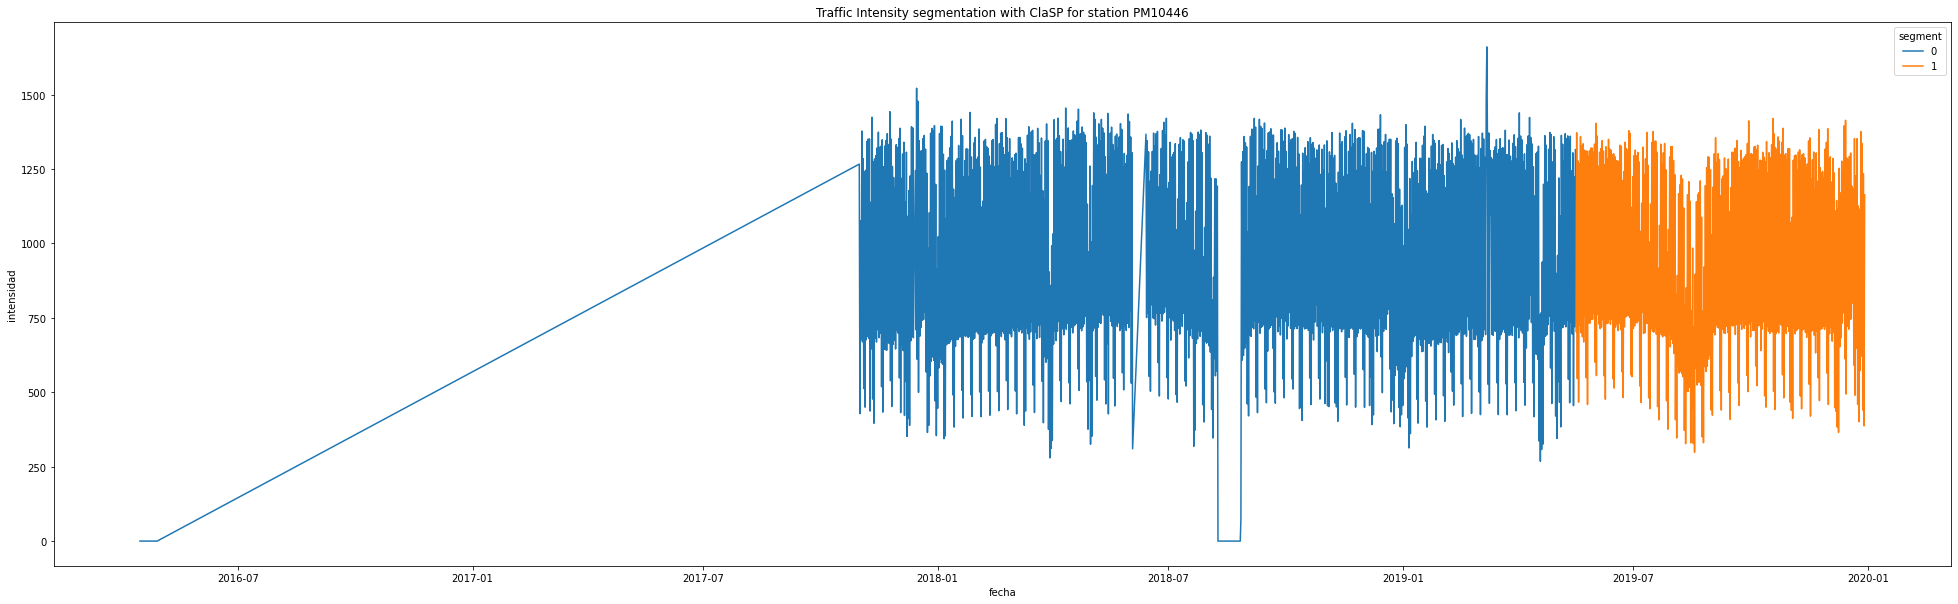

In [6]:
# Visualize segments
fig,ax = plt.subplots(figsize=(34,10))
# ts_df.plot(x="fecha",y="intensidad",ax=ax,color="segment")
ax = sns.lineplot(data=ts_df,x="fecha",y="intensidad",ax=ax,hue="segment")
ax.set_title(f"Traffic Intensity segmentation with ClaSP for station {station_cod}");

## Change-point detection and forecasting with Prophet

In [147]:
# Change-point detection with Prophet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot, plot_yearly

from IPython.display import display

%matplotlib inline
pd.options.plotting.backend = "plotly"


In [ ]:
import pandas as pd
pd.read_feather("../01-data/processed/traffic_data.feather")

In [117]:
madrid_df = pd.read_feather("../01-data/processed/madrid_air_quality_data.feather")
aq_df = pd.read_feather("../01-data/processed/air_quality_data.feather")
aq_df.head()

time                 estacion  ben_µg_m3  ch4_mg_m3  \
0 2014-01-01 00:00:00+00:00           Plaza Elíptica        NaN        NaN   
1 2014-01-01 00:00:00+00:00                 Vallecas        NaN        NaN   
2 2014-01-01 00:00:00+00:00  Urb. Embajada (Barajas)        0.9       1.32   
3 2014-01-01 00:00:00+00:00              Tres Olivos        NaN        NaN   
4 2014-01-01 00:00:00+00:00              Sanchinarro        NaN        NaN   

   co_mg_m3  ebe_µg_m3  nmhc_mg_m3  no2_µg_m3  no_µg_m3  nox_µg_m3  o3_µg_m3  \
0       0.3        NaN         NaN       14.0       4.0       19.0     46.50   
1       NaN        NaN         NaN       20.0       5.0       28.0       NaN   
2       NaN        0.7        0.15       18.0       2.0       21.0       NaN   
3       NaN        NaN         NaN       12.0       1.0       13.0     50.92   
4       0.2        NaN         NaN       14.0       1.0       16.0       NaN   

   pm10_µg_m3  pm25_µg_m3  so2_µg_m3  tch_mg_m3  tol_µg_m3  
0         NaN         NaN        NaN        NaN        NaN  
1        30.0         NaN        3.0        NaN        NaN  
2        22.0         NaN        NaN       1.48        0.6  
3        18.0         NaN        NaN        NaN        NaN  
4         5.0         NaN        8.0        NaN        NaN

In [114]:
aq_df.estacion.unique()

array(['Plaza Elíptica', 'Vallecas', 'Urb. Embajada (Barajas)',
       'Tres Olivos', 'Sanchinarro', 'Retiro', 'Pº. Castellana',
       'Pza. del Carmen', 'Pza. de España', 'Pza. Castilla',
       'Parque Juan Carlos I', 'Villaverde Alto', 'Moratalaz',
       'Arturo Soria', 'Av. Ramón y Cajal', 'Barajas', 'Barrio del Pilar',
       'C/ Farolillo', 'Méndez Álvaro', 'Cuatro Caminos', 'El Pardo',
       'Ensanche Vallecas', 'Escuelas Aguirre', 'Casa de Campo'],
      dtype=object)

In [171]:
indicator = "no2_µg_m3"
station = "Pza. del Carmen"

start = "2016-01-01"
end = "2019-01-01"

future_start = "2019-01-01"
future_end = "2022-01-01"

# Preprocess data
# make tz unaware
X = aq_df[(aq_df.estacion==station)].rename(columns={"time":"ds",indicator:"y"})
X.ds = X.ds.dt.tz_localize(None)

# Train and test split
X_train = X[(X.ds<future_start)&(X.ds>=start)].copy()
X_test = X[(X.ds>=future_start)&(X.ds<=future_end)].copy()

fig = X.rename(columns={"y":indicator})\
        .plot(x="ds",y=indicator,title=f"Timeseries of {indicator.split('_')[0]} for {station}")
# add vertical line to plotly plot to display train and test split
fig.add_vline(
        x=X_train.ds.max(),
        line={"color": "red"},
        line_width=2,
        line_dash="dot",
        # annotation_text="Train-Test split",
)

In [137]:
# Instantiate Prophet, fit model, and predict
m = Prophet(changepoint_prior_scale=0.05,changepoint_range=0.95)

m.add_country_holidays(country_name='ES')
m.fit(X);

future = m.make_future_dataframe(periods=24*30*6,freq='H')

forecast = m.predict(future)

Initial log joint probability = -1204.24
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       43122.6     0.0036987       287.881           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       43173.8    0.00465614       211.386       0.943       0.943      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       43188.5     0.0306952       459.588           1           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       43199.2      0.013284       391.492           1           1      469   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       43208.5     0.0115078       262.608           1           1      594   
    Iter      log prob        ||dx||      ||grad||       alpha  

5 changepoints detected
changepoints:


['2016-04-18T09:00',
 '2017-11-05T01:00',
 '2019-01-20T11:00',
 '2019-05-11T02:00',
 '2019-08-27T15:00']

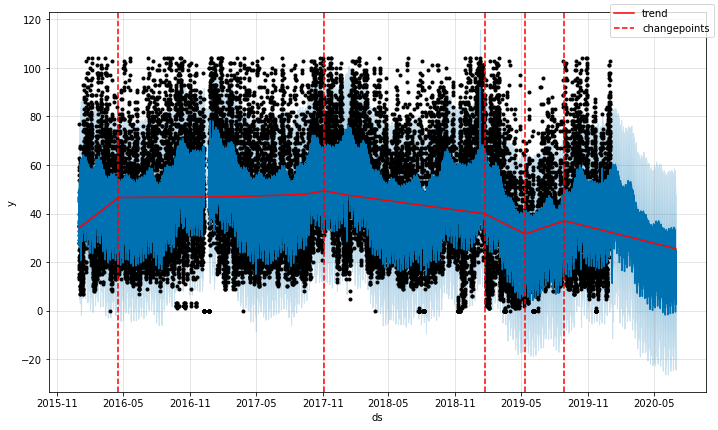

In [141]:
fig = m.plot(forecast)

changepoints_thresh = 0.75
changepoints = m.changepoints[np.abs(np.nanmean(m.params["delta"],axis=0)) >= changepoints_thresh]

lines = add_changepoints_to_plot(
    fig.gca(), m, forecast,
    threshold=changepoints_thresh,
)

fig.legend(handles=lines[0]+[lines[1]],labels=["trend","changepoints"])

print(f"{len(changepoints)} changepoints detected")
print("changepoints:")
display(changepoints.dt.strftime("%Y-%m-%dT%H:%M").tolist())

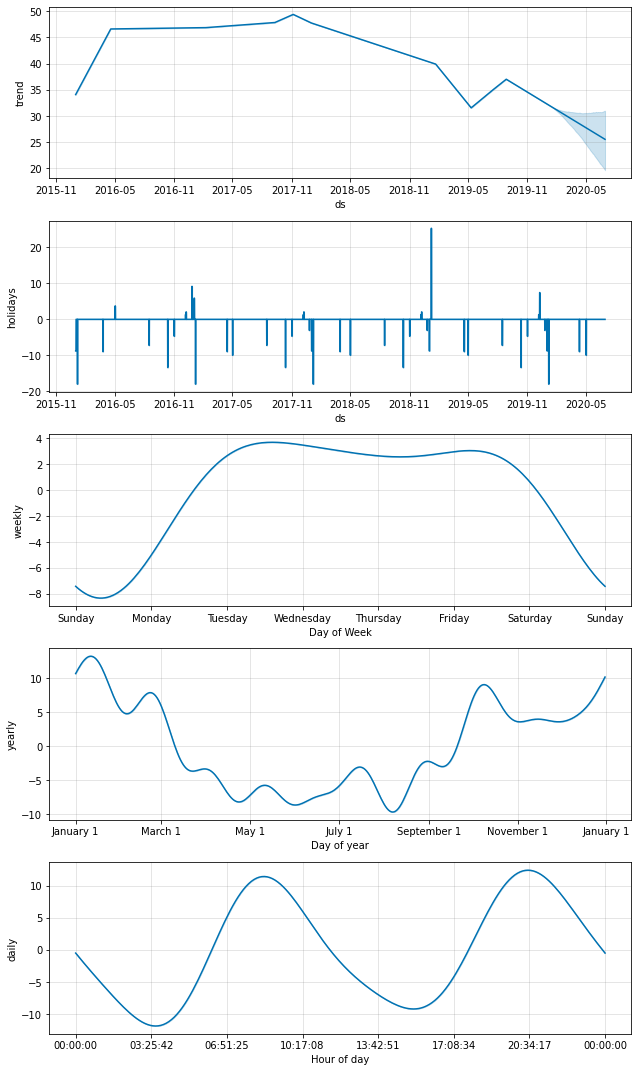

In [146]:
fig = m.plot_components(forecast)
fig.show()